In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup, Comment
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(8559)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 500)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
len(input_dirs)

2

In [4]:
len(input_dirs[INVESTIGATE_DIR])

475

In [5]:
len(input_dirs[IGNORE_DIR])

500

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
        d['return_path_match_from'] = 1
    else:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    #'subject_len': mail_dict['subject_len'],
                    #'body_len': mail_dict['body_len'],
                    #'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    #'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    #'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    #'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    #'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    #'return_path_match_from': mail_dict['return_path_match_from'],
                    #'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    #'Content-type': mail_dict['Content-type'],
                    #'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    #'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    #'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    #'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    #'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    #'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    #'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    #'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    #'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    #'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    #'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    #'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    #'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    #'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    #'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    #'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    #'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    #'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    #'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    #'has_defects': mail_dict['has_defects'],
                    #'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    #'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Validate your Office 365 account.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem 3.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- New Documents Survey For Your Review[10].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice from Karen Laman.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your files were sent successfully to dgassaway@johnson.motosnap.com and 97 others[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-637290015585-228.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 7 Past Due Invoices.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Erinnerung an die Rechnungszahlung.eml
/Users/worsh

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice 13329 from Transpro[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- RE-Request.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice for l-a 02-22-2018.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- kblack@wylaco.com sent you files via WeTransfer.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Wish you a Merry Christmas!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Have a wonderful Christmas and a joyous New Year!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Pat due invoice notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Completed- Please DocuSign these documents.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice number 22028027-LFYJ#WDBB-2017 (27 Nov 17) No

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- PAC Invoice CD99133732.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- NEW QUOTATION[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- New payment notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- FinWise Bank-4-06-2018.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] UPS Delivery Notification, Tracking Number 1Z9R140W0358552191[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Please send copy invoice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Ship Notification, Tracking Number 8PEO80268803644920.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice 265720 from Don Losasso.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Wish you a Merry Christmas![1].eml
/Users/wor

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 28-09HSBC Confirmation slip.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Andy Jessen Paypal Receipt.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE STATUS.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Scan 62894016185 Loni Bennett.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Statement from  andy.j@pateconcreteinc.com.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Please Review Listing.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- All the best in Coming Year!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Validate Your LinkedIn Account.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment problem.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Add

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Confidential- FYI[2].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Please Review Listing[2].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Emailing2018-04-17-4dfb-4c20-8d32-cw58eb31eda6.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- New Documents Survey For Your Review[7].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- May Service and Support Invoice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Problem with an invoice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice #33283473-IJD#ALONQ-2017 (14 Nov 17).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] 907-64-653485-982-907-64-653485-891.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Updated Invitation 2018.eml
/Users/worshamn

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Versandbestätigung und Rechnung - Bestellung 496632974.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- New Documents Survey For Your Review[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] UPS Invoice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Overdue payment.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice # 7338953249 Problem.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- C Fisher.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your Legally Binding Contract document is ready for signature![1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your Legally Binding Contract document is ready for signature!.eml
/Users/worshamn/

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\ '


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Limited Quantities- Free AMC Movie Tickets[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] 2018 Small Business Tour[9].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Sonia, review us on Google.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Hi Nicole!  Kids Ninja Warrior Competition.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Managing Machine Data (Logs)[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- My dear you a romantic person.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- We Do More Than You Think We Do.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Tomorrow- Your Data Center's Speed & Resiliency. Amazon card..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Real estate is changing. Are you affected.eml
/Users/wor

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Remaining Oracle Workshops for 2017.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Local Cyber Security[2].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Urge your Senators to vote NO on the tax reform bill.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- The most viewed episode this year[2].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Documenting Misconduct so Your Decisions Stand Up in Court.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Accurate Emails List  [1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Tosha, Reward Yourself with 80,000 Bonus Points.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Check out my new website Education in Pursuit LLC Kay Ward, CPCU, AIS, ACS, AAI  [2].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] F

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\_'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Webinar]- Insights on Cloud & Managed Print Services with KeyPoint Intelligence and Xerox[2].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- → 7 Jobs for Customer Service Representative - Denver[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Talent Management Excellence  Get the emPerform Newsletter.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Why You Should Care About Ransomware- Exclusive White Paper Inside![1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- A safe way to get rid of skin tags.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Unexpected shipment for YOU 👉.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Ashley  Security Projects  Crowdstrike.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Special Invitation[2].eml
/Users/worshamn/Docume

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\>'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Now, you can add a friend to your instagram live; here’s how it works[2].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Assigned To Course.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Planning Your Migration to the Microsoft Cloud.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Get a 60k salary with this degree.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Jim, please update your profile.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Turns out the Shark Tank cast can agree.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Do you want to be smarter[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Network Outages[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Get ahead with mental focus pills.eml
/Users/worshamn/Documents

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Office of Civil Rights OCR is Sending Audit Screening Questionnaires to Covered Entities now. Next Steps and how to Comply.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- WageWorks Email Enhancements[2].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- For our employees- Your gift discount directory[2].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Leapfrog-  Managed IT Services - Security Assessments - Helpdesk Support - Disaster Recovery   CO M1.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- for Amanda Gould.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- The FASB's new revenue recognition guidance.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Notification of Inactivity.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Improve Personnel Planning with Prophix

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\#'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Shark Tank shocks the world again.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- GOLD EXCHANGE[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [99].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Seduce any woman any time with this incredible secret..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- ENDS TODAY- Free Registration CreatorCon.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- FSA Store For Allergy Season[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Exclusive Customer Appreciation Sale.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- for Rhonda Isham[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- This will force your body into ketosis without counting carbs..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish A

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- interview about your apprenticeship.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] 60,000 Business Owners[18].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You have new life insurance rates.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- PM Training sessions - Nov 27 - 30[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Look smart in front of your boss[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [8].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- recent content from AIG.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Support Analyst jobs from Virtual Vocations, Xactly Corp., and more.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Litigating Claims Against Accountants CLE.eml
/Users/worshamn/Documents/emailProject/Ignor

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- New Custom Grind Wedge, On the House![1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Put down that BP medicine[2].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Intentions are important, but action is essential[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- I Wouldn't Want To Be In This Convertible!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Join Us at Del Frisco's for an IoT Discussion with IDC.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Opportunity Engagement[1].eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Project ManagementProfessional certification course.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Mini spy camera connects to any outlet.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- This week[1].eml
/Users/wor

Convert cells that are not recognized as a number or just to get rid of float

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 2 columns):
target    975 non-null object
text      975 non-null object
dtypes: object(2)
memory usage: 15.3+ KB


In [11]:
df.text.iloc[50]

"cschultz@ironwomancon.com sent you files via WeTransfer Get your files     Click 'Download images' to view images      cschultz@ironwomancon.com    sent you some files   1 file, 44.9 KB in total   Get your files        Download link  https://wetransfer.com/downloads/afe70c67af1520e3ea919cd4c21e958a20180521173535/b6d72890eb2c97f07608d369eec817a320180521173602/7a1e75    1 file  ironwomancon_invoice.html    To make sure our emails arrive, please add noreply@wetransfer.com   to your contacts  .  About WeTransfer     ・   Help     ・   Legal     ・   Report this transfer as spam  "

Create a function to clean the text

In [12]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
#         str(d).lower().translate(table).replace('\n',' ')
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
    #         stopwords_nltk = sorted(nltk.corpus.stopwords.words('english'))
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
                #if (w.lemma_ != '-PRON-' and len(w.lemma_)>term_min_len)
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs
    
#     if not remove_stopwords:
#         # remove stopwords
#         #stopwords = nltk.corpus.stopwords.words('english')
#         print('lemmatization')
#         lemmatized_docs = [
#             [
#                 w.lemma_ 
#                 if w.lemma_ != '-PRON-'
#                 else w.lower_
#                 for w in d
#             ]
#             for d in nlp_docs
#         ]
        #lemmatized_docs = [
        #    [
        #        lemma 
        #        for lemma in doc
        #    ] 
        #    for doc in lemmatized_docs
        #]
    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Text the text cleaning

In [13]:
text = [
    "Validate your Office 365 account       You have a new message from the Microsoft Office team.  View Message ",
    "Invoice Problem Hello Jessica Rael,    Wasn’t lucky enough to get in touch with your the other day. Anyways, hopefully you can get back to me  about this invoice below.  Invoice Problem: http://hajnalattila.hu/Document/New-invoice-534677/    Thanks, Shannon Hazzard",
    "Not A law firms.",
    "test www.cnn.com. Candy land is my favorite workers comp www.google.com game",
    "LIBRARY: WWW.CLICWEB.ORG",
    "cschultz@ironwomancon.com sent you files via WeTransfer Get your files     Click 'Download images' to view images      cschultz@ironwomancon.com    sent you some files   1 file, 44.9 KB in total   Get your files        Download link  https://wetransfer.com/downloads/afe70c67af1520e3ea919cd4c21e958a20180521173535/b6d72890eb2c97f07608d369eec817a320180521173602/7a1e75    1 file  ironwomancon_invoice.html    To make sure our emails arrive, please add noreply@wetransfer.com   to your contacts  .  About WeTransfer     ・   Help     ・   Legal     ・   Report this transfer as spam  ",
]
clean_text(text, remove_stopwords=False)

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization


['validate your office   account        you have a new message from the microsoft office team   view message',
 'invoice problem hello jessica rael     be not lucky enough to get in touch with your the other day anyways hopefully you can get back to me   about this invoice below   invoice problem      thank shannon hazzard',
 'not a law firm',
 'test   candy land be my favorite worker comp   game',
 'library',
 '  send you file via wetransfer get your file      click download image to view image           send you some file     file   kb in total    get your file         download link        file   ironwomanconinvoicehtml     to make sure our email arrive please add     to your contact     about wetransfer      ・    help      ・    legal      ・    report this transfer as spam  ']

In [14]:
from time import time
t0 = time()
corpus = clean_text(
    df['text'],
    remove_stopwords = False,
)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization
done in 10.664s


In [15]:
df['cleaned_text'] = pd.Series(corpus).values

In [16]:
df.sample(10,random_state=123)

,target,text,cleaned_text
877,ignore,Upcoming March Complimentary Workshops Hello J...,upcoming march complimentary workshop hello ji...
764,ignore,"Fw: for Amanda Gould On Wednesday, October 18,...",fw for amanda gould on wednesday october b...
788,ignore,"Quick Question | Oracle Resource Team Jim, ...",quick question oracle resource team jim ...
727,ignore,[Spam] Congrats! You've Been Selected for Comp...,spam congrat you have be select for compliment...
898,ignore,[Spam] 2018 Small Business Tour The 2018 Small...,spam small business tour the small busines...
894,ignore,"Hi Angelina, we'd love to hear your thoughts H...",hi angelina we would love to hear your thought...
317,investigate,PDF-20180327072018.PDF Please refer to the Att...,pdfpdf please refer to the attach and get back...
138,investigate,-ðð¦ð©ð¨ð«ð­ðð§ð­ ðÌð...,ðð ¦ ð © ð¨ð«ð­ðð§ð­ ðì...
915,ignore,"RSA | Request for Discussion Good Morning Jim,...",rsa request for discussion good morning jim ...
498,ignore,"Sonia, review us on Google Hi Sonia. Add your ...",sonia review us on google hi sonia add your re...


Drop any rows that have cleaned themselves to nothing (or had nothing to begin with)

In [17]:
df['cleaned_text'].replace(r'',np.nan,regex=True, inplace=True)
df.dropna(inplace=True,subset=['cleaned_text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 974
Data columns (total 3 columns):
target          974 non-null object
text            974 non-null object
cleaned_text    974 non-null object
dtypes: object(3)
memory usage: 30.4+ KB


In [18]:
df[df['cleaned_text']=='']

,target,text,cleaned_text


Split the sample set into test and training sets

In [19]:
df_target = df['target']
df_feats = df['cleaned_text']
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350
)

In [20]:
df_feats.head()

0    goodchem document review attach document and v...
1    validate your office   account        you have...
2    invoice problem hello jessica rael     be not ...
3    new document survey for your review document r...
4    invoice from karen laman please see attached i...
Name: cleaned_text, dtype: object

TFIDF Creation

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    #max_df=0.9, 
    min_df=2,
    use_idf=False,
    binary=True,
)
train_feats = vectorizer.fit_transform(train_feats.values.tolist())
test_feats = vectorizer.transform(test_feats.values.tolist()) 
# train_feats = vectorizer.fit_transform([' '.join(i) for i in train_feats.values.tolist()])
# test_feats = vectorizer.transform([' '.join(i) for i in test_feats.values.tolist()]) 
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.752s


In [22]:
train_feats.shape

(779, 26003)

In [23]:
test_feats.shape

(195, 26003)

#### SVM

In [24]:
from sklearn.svm import LinearSVC 
t0 = time()
svm_clf = LinearSVC(random_state=7350)
svm_clf.fit(train_feats, train_labels)
#svm_pred = svm_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.018s


Start by seeing how it scores on the data it has already seen

In [25]:
svm_clf.score(train_feats, train_labels)

0.9961489088575096

Then score it on data it has not seen

In [26]:
svm_clf.score(test_feats, test_labels)

0.9435897435897436

In [27]:
from sklearn.svm import SVC 
t0 = time()
svmr_clf = SVC(random_state=7350)
svmr_clf.fit(train_feats, train_labels)
#svmr_pred = svmr_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.506s


In [28]:
svmr_clf.score(train_feats, train_labels)

0.5019255455712451

In [29]:
svmr_clf.score(test_feats, test_labels)

0.5538461538461539

#### Extra Trees Classifier

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
t0 = time()
et_clf = ExtraTreesClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
et_clf.fit(train_feats, train_labels)
#et_pred = et_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.370s


In [31]:
et_clf.score(train_feats, train_labels)

1.0

In [32]:
et_clf.score(test_feats, test_labels)

0.9384615384615385

Get Feature Importances

In [33]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. unsubscribe (0.013966)
2. invoice (0.013209)
3. with (0.006215)
4. on (0.006103)
5. to (0.004965)
6. how (0.004921)
7. re (0.004750)
8. of (0.004651)
9. please (0.004207)
10. thank (0.004007)
11. about (0.003987)
12. what (0.003899)
13. more (0.003872)
14. solution (0.003851)
15. event (0.003446)
16. off (0.003342)
17. the (0.003337)
18. like (0.003269)
19. hi (0.003263)
20. to receive (0.003218)
21. these (0.003214)
22. our (0.003168)
23. first (0.003152)
24. learn (0.003126)
25. product (0.003045)


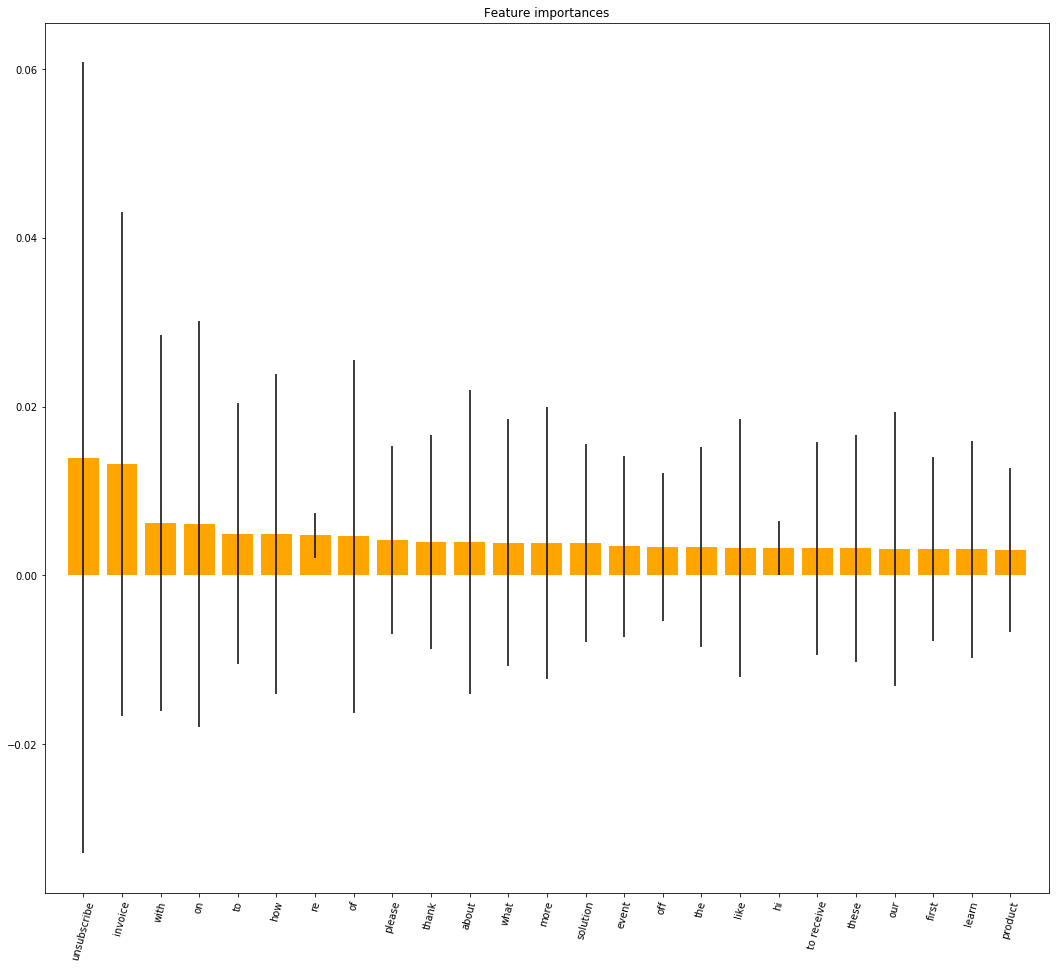

In [34]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Gradient Boost

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
gb_clf = GradientBoostingClassifier(n_estimators=100,random_state=7350)
gb_clf.fit(train_feats, train_labels)
#gb_pred = gb_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 3.147s


In [36]:
gb_clf.score(train_feats, train_labels)

0.9961489088575096

In [37]:
gb_clf.score(test_feats, test_labels)

0.9128205128205128

#### XGBoost

In [38]:
from xgboost import XGBClassifier
t0 = time()
xgb_clf = XGBClassifier(max_depth=5,random_state=7350,n_estimators=100,n_jobs=-1)
xgb_clf.fit(train_feats, train_labels)
#xgb_pred = xgb_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 2.699s


In [39]:
xgb_clf.score(train_feats, train_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9794608472400513

In [40]:
xgb_clf.score(test_feats, test_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8974358974358975

#### Neural Net

In [41]:
from sklearn.neural_network import MLPClassifier
t0 = time()
nn_clf = MLPClassifier(max_iter=800)
nn_clf.fit(train_feats, train_labels)
#nn_pred = nn_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 37.510s


In [42]:
nn_clf.score(train_feats, train_labels)

1.0

In [43]:
nn_clf.score(test_feats, test_labels)

0.9538461538461539

#### Naive Bayes

In [44]:
from sklearn.naive_bayes import MultinomialNB
t0 = time()
nb_clf = MultinomialNB(alpha=.001)
nb_clf.fit(train_feats, train_labels)
#nb_pred = nb_clf.predict(test_feats.drop('TAP-Score',axis=1))
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.007s


In [45]:
nb_clf.score(train_feats, train_labels)

0.9858793324775353

In [46]:
nb_clf.score(test_feats, test_labels)

0.958974358974359

In [47]:
# from sklearn.naive_bayes import GaussianNB
# t0 = time()
# gnb_clf = GaussianNB()
# gnb_clf.fit(train_feats, train_labels)
# #gnb_pred = gnb_clf.predict(test_feats.drop('TAP-Score',axis=1))
# print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

In [48]:
# gnb_clf.score(train_feats.drop('TAP-Score',axis=1), train_labels)

In [49]:
# gnb_clf.score(test_feats.drop('TAP-Score',axis=1), test_labels)

#### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
rf_clf.fit(train_feats, train_labels)
#rf_pred = rf_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.403s


In [51]:
rf_clf.score(train_feats, train_labels)

1.0

In [52]:
rf_clf.score(test_feats, test_labels)

0.9076923076923077

In [53]:
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. unsubscribe (0.013966)
2. invoice (0.013209)
3. with (0.006215)
4. on (0.006103)
5. to (0.004965)
6. how (0.004921)
7. re (0.004750)
8. of (0.004651)
9. please (0.004207)
10. thank (0.004007)
11. about (0.003987)
12. what (0.003899)
13. more (0.003872)
14. solution (0.003851)
15. event (0.003446)
16. off (0.003342)
17. the (0.003337)
18. like (0.003269)
19. hi (0.003263)
20. to receive (0.003218)
21. these (0.003214)
22. our (0.003168)
23. first (0.003152)
24. learn (0.003126)
25. product (0.003045)


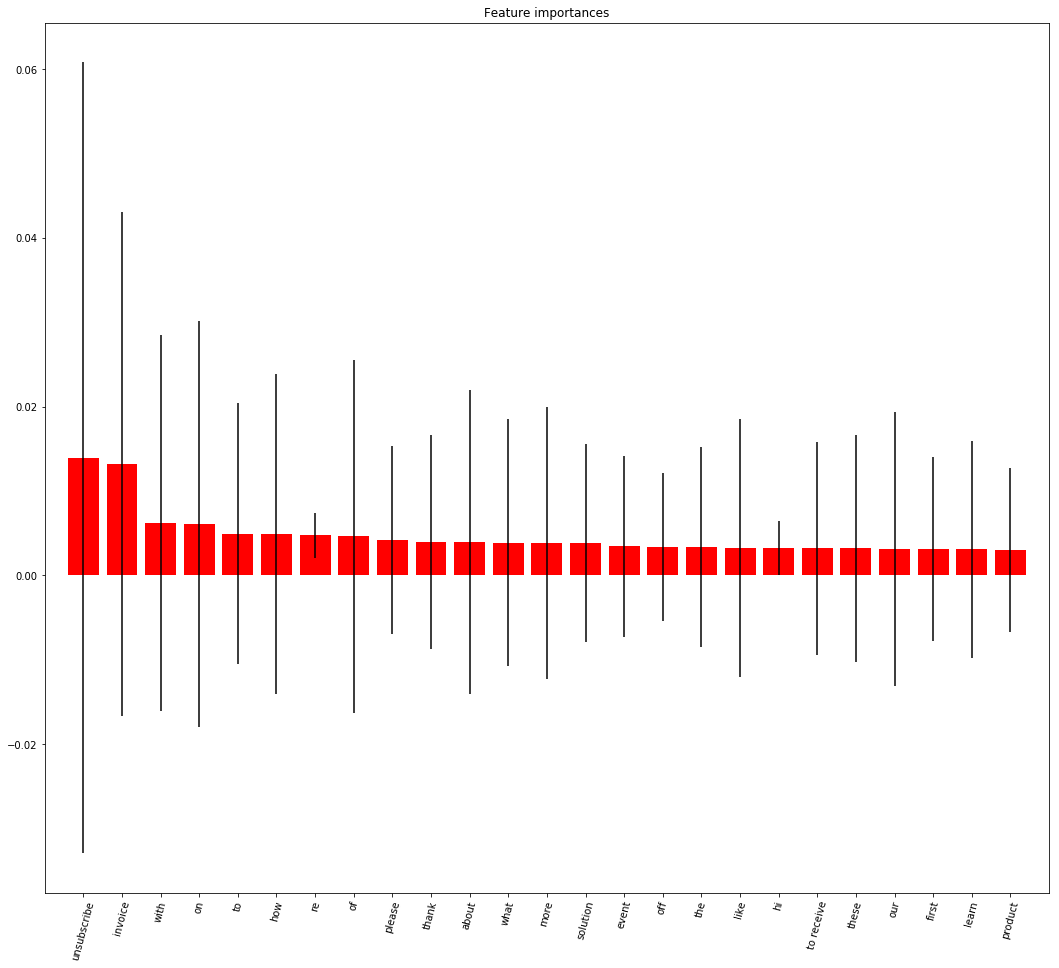

In [54]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="red", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Nearest Neighbors

In [55]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
knn_clf = KNeighborsClassifier(n_jobs=-1,leaf_size=100)
knn_clf.fit(train_feats, train_labels)
#knn_pred = rf_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.005s


In [56]:
knn_clf.score(train_feats, train_labels)

0.6983311938382541

In [57]:
knn_clf.score(test_feats, test_labels)

0.676923076923077

In [58]:
from sklearn.neighbors import NearestCentroid
t0 = time()
nc_clf = NearestCentroid()
nc_clf.fit(train_feats, train_labels)
#nc_pred = rf_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.014s


In [59]:
nc_clf.score(train_feats, train_labels)

0.9306803594351734

In [60]:
nc_clf.score(test_feats, test_labels)

0.9128205128205128

#### AdaBoost

In [61]:
from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ab_clf = AdaBoostClassifier(n_estimators=100,random_state=7350)
ab_clf.fit(train_feats, train_labels)
#ab_pred = ab_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 1.476s


In [62]:
ab_clf.score(train_feats, train_labels)

1.0

In [63]:
ab_clf.score(test_feats, test_labels)

0.882051282051282

#### QuadraticDiscriminantAnalysis

In [64]:
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# t0 = time()
# qda_clf = QuadraticDiscriminantAnalysis()
# qda_clf.fit(train_feats, train_labels)
# #qda_pred = qda_clf.predict(test_feats)
# print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

In [65]:
# qda_clf.score(train_feats, train_labels)

In [66]:
# qda_clf.score(test_feats, test_labels)

#### GaussianProcessClassifier

In [67]:
# from sklearn.gaussian_process import GaussianProcessClassifier
# t0 = time()
# gp_clf = GaussianProcessClassifier(random_state=7350)
# gp_clf.fit(train_feats, train_labels)
# #gp_pred = gp_clf.predict(test_feats)
# print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

In [68]:
# gp_clf.score(train_feats, train_labels)

In [69]:
# gp_clf.score(test_feats, test_labels)

#### Decision Tree

In [70]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
dt_clf = DecisionTreeClassifier(random_state=7350)
dt_clf.fit(train_feats, train_labels)
#dt_pred = dt_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.186s


In [71]:
dt_clf.score(train_feats, train_labels)

1.0

In [72]:
dt_clf.score(test_feats, test_labels)

0.8717948717948718

#### LogisticRegression

In [73]:
from sklearn.linear_model import LogisticRegression
t0 = time()
lr_clf = LogisticRegression(random_state=7350)
lr_clf.fit(train_feats, train_labels)
#lr_pred = lr_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.023s


In [74]:
lr_clf.score(train_feats, train_labels)

0.9653401797175867

In [75]:
lr_clf.score(test_feats, test_labels)

0.9384615384615385

#### PassiveAggressiveClassifier

In [76]:
from sklearn.linear_model import PassiveAggressiveClassifier
t0 = time()
pa_clf = PassiveAggressiveClassifier(n_jobs=-1,random_state=7350)
pa_clf.fit(train_feats, train_labels)
#pa_pred = pa_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.015s


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [77]:
pa_clf.score(train_feats, train_labels)

0.9961489088575096

In [78]:
pa_clf.score(test_feats, test_labels)

0.9435897435897436

#### RidgeClassifier

In [79]:
from sklearn.linear_model import RidgeClassifier
t0 = time()
rd_clf = RidgeClassifier(random_state=7350)
rd_clf.fit(train_feats, train_labels)
#rd_pred = rd_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.081s


In [80]:
rd_clf.score(train_feats, train_labels)

0.9910141206675225

In [81]:
rd_clf.score(test_feats, test_labels)

0.9435897435897436

#### SGDClassifier

In [82]:
from sklearn.linear_model import SGDClassifier
t0 = time()
sgd_clf = SGDClassifier(random_state=7350)
sgd_clf.fit(train_feats, train_labels)
#sgd_pred = sgd_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.004s


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [83]:
sgd_clf.score(train_feats, train_labels)

1.0

In [84]:
sgd_clf.score(test_feats, test_labels)

0.9487179487179487

#### CalibratedClassifierCV

In [85]:
from sklearn.calibration import CalibratedClassifierCV
t0 = time()
cc_clf = CalibratedClassifierCV()
cc_clf.fit(train_feats, train_labels)
#cc_pred = cc_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 0.069s


In [86]:
cc_clf.score(train_feats, train_labels)

0.9948652118100129

In [87]:
cc_clf.score(test_feats, test_labels)

0.9435897435897436

#### BaggingClassifier

In [88]:
from sklearn.ensemble import BaggingClassifier
t0 = time()
bg_clf = BaggingClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
bg_clf.fit(train_feats, train_labels)
#bg_pred = bg_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,_clf)

done in 6.511s


In [89]:
bg_clf.score(train_feats, train_labels)

1.0

In [90]:
bg_clf.score(test_feats, test_labels)

0.8871794871794871

#### VotingClassifier

In [115]:
from sklearn.ensemble import VotingClassifier
t0 = time()
vt_clf = VotingClassifier(estimators=[
#     ('nn',nn_clf),
    ('nb',nb_clf),
#     ('et',et_clf),
    ('sgd',sgd_clf),
#     ('svm',svm_clf),
#     ('pa',pa_clf),
#     ('nc',nc_clf),
#     ('lr',lr_clf),
#     ('cc',cc_clf),
    ('rd',rd_clf),
#     ('rf',rf_clf),
])
vt_clf.fit(train_feats, train_labels)
#vt_pred = vt_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))

done in 0.100s


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [116]:
vt_clf.score(train_feats, train_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9948652118100129

In [117]:
vt_clf.score(test_feats, test_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9538461538461539